# Trigger efficiency

(for EXO-workshop2019)

Logic OR of DoubleL2MuNoVtx triggers in 2018 menu wrt. leptonjets reco V2.<br/>
Efficiency vs. PFMu/DSAMu-type leptonjet pT, lxy for 4mu, 2mu2e samples

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from awkward import JaggedArray
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
from FireHydrant.Tools.trigger import Triggers
import awkward

np.seterr(divide='ignore', invalid='ignore', over='ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from os.path import join
import os
import json
datasets_2mu2e = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))
datasets_4mu = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
datasets = {'2mu2e':[], '4mu': []}
for k,v in datasets_2mu2e.items():
    if not k.endswith('lxy-300'):
        continue
    datasets['2mu2e'].extend(v)
for k,v in datasets_4mu.items():
    if not k.endswith('lxy-300'):
        continue
    datasets['4mu'].extend(v)

In [3]:
class triggerProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        binning = np.concatenate([np.arange(0, 1, 0.1),
                                  np.arange(1,10,1),
                                  np.arange(10,100, 5),
                                  np.arange(100, 300, 10),
                                  np.arange(300, 600, 25)
                                 ])
        dpvxy_axis = hist.Bin('dpvxy', 'darkphoton lxy [cm]', binning)
        lxy_axis = hist.Bin('lxy', 'lxy [cm]', [0, 2.9, 16, 70, 170, 290, 600])
        pt_axis = hist.Bin("pt", r"$p_T$ [GeV]", np.concatenate([np.arange(0, 100, 10), np.arange(100, 250, 25), np.arange(250, 500, 50)]))
        dr_axis = hist.Bin('dr', '$\DeltaR$', 50, 0, 0.5)
        sdist_axis = hist.Bin('dist', 'distance on extrapolated surface[cm]', 50, 0, 5)
        mdist_axis = hist.Bin('dist', 'distance on extrapolated surface[cm]', 50, 0, 25)
        dist_axis = hist.Bin('dist', 'distance on extrapolated surface[cm]', 50, 0, 100)
        trigger_axis = hist.Cat('trigger', 'triggered')
        type_axis = hist.Cat('type', 'decay product')
        self._accumulator = processor.dict_accumulator({
            'dpvxy': hist.Hist("Counts", dataset_axis, dpvxy_axis, trigger_axis),
            'pt': hist.Hist("Counts", dataset_axis, pt_axis, trigger_axis),
            'pt_': hist.Hist("Counts", dataset_axis, pt_axis, trigger_axis, lxy_axis),
            'dr': hist.Hist("Counts", dataset_axis, dr_axis, trigger_axis),
            'dist0': hist.Hist("Counts", dataset_axis, sdist_axis, trigger_axis),
            'dist1': hist.Hist("Counts", dataset_axis, mdist_axis, trigger_axis),
            'dist2': hist.Hist("Counts", dataset_axis, dist_axis, trigger_axis),
            'dist3': hist.Hist("Counts", dataset_axis, dist_axis, trigger_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        trigger=np.logical_or.reduce([df[t] for t in Triggers])
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolation05'].content,
            ncands=df['pfjet_pfcands_n'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
            daupid=df['gen_daupid'].content,
            dauvx=df['gen_dauvtx.fCoordinates.fX'].content,
            dauvy=df['gen_dauvtx.fCoordinates.fY'].content,
            dauvz=df['gen_dauvtx.fCoordinates.fZ'].content,
            daudr=df['gen_daudr'].content,
        )
        genparticles.add_attributes(daurho=np.hypot(genparticles.dauvx, genparticles.dauvy))
        bdr=awkward.fromiter(df['gen_dauposdr'])
        bdrf=bdr.flatten()
        bdrBPix=JaggedArray.fromoffsets(bdr.offsets, bdrf.pad(1).fillna(-1)[:, :1]).flatten(axis=1)
        bdrTOB=JaggedArray.fromoffsets(bdr.offsets, bdrf.pad(2).fillna(-1)[:, 1:2]).flatten(axis=1)
        bdrMB2=JaggedArray.fromoffsets(bdr.offsets, bdrf.pad(3).fillna(-1)[:, 2:3]).flatten(axis=1)
        bdrMB3=JaggedArray.fromoffsets(bdr.offsets, bdrf.pad(1).fillna(-1)[:, -1:]).flatten(axis=1)
        
        genparticles.add_attributes(drbpix=bdrBPix, drtob=bdrTOB, drmb2=bdrMB2, drmb3=bdrMB3) # distance extrapolated at MB3 cylinder

        is_dpToEl = (genparticles.pid==32)&(genparticles.daupid==11)
        is_dpToMu = (genparticles.pid==32)&(genparticles.daupid==13)
        darkphotons_el = genparticles[is_dpToEl]
        darkphotons_mu = genparticles[is_dpToMu]
        
        muljs = leptonjets[leptonjets.ismutype]
        ge1_mulj = muljs.counts>0
        
        muljs = muljs[ge1_mulj]
        darkphotons_mu = darkphotons_mu[ge1_mulj]
        trigger = trigger[ge1_mulj]
        if muljs.size==0 or darkphotons_mu.size==0: return output

        
        output['pt'].fill(dataset=dataset, trigger='true', pt=muljs[trigger].pt.flatten())
        output['pt'].fill(dataset=dataset, trigger='false', pt=muljs[~trigger].pt.flatten())
        
        matchedDarkphotonIdx = muljs.argmatch(darkphotons_mu, deltaRCut=0.4)
        _foundMatch = matchedDarkphotonIdx!=-1
        m_muljs = muljs[_foundMatch]
        m_dp = darkphotons_mu[matchedDarkphotonIdx[_foundMatch]]
        output['pt_'].fill(dataset=dataset, trigger='true', pt=m_muljs[trigger].pt.flatten(), lxy=m_dp[trigger].daurho.flatten())
        output['pt_'].fill(dataset=dataset, trigger='false', pt=m_muljs[~trigger].pt.flatten(), lxy=m_dp[~trigger].daurho.flatten())
        
        matchmask = darkphotons_mu.match(muljs, deltaRCut=0.4)
        matched_darkphotons = darkphotons_mu[matchmask]
        if matched_darkphotons.size==0: return output
        
        output['dpvxy'].fill(dataset=dataset, trigger='true', dpvxy=matched_darkphotons[trigger].daurho.flatten())
        output['dpvxy'].fill(dataset=dataset, trigger='false', dpvxy=matched_darkphotons[~trigger].daurho.flatten())
        
        output['dr'].fill(dataset=dataset, trigger='true', dr=matched_darkphotons[trigger].daudr.flatten())
        output['dr'].fill(dataset=dataset, trigger='false', dr=matched_darkphotons[~trigger].daudr.flatten())
        
        barrel_darkphotons = matched_darkphotons[np.abs(matched_darkphotons.eta)<0.9]
        if barrel_darkphotons.size==0: return output
        
        barrel_darkphotons0 = barrel_darkphotons[barrel_darkphotons.daurho<3.]
        if barrel_darkphotons0.size!=0:
            output['dist0'].fill(dataset=dataset, trigger='true', dist=barrel_darkphotons0[trigger].drbpix.flatten())
            output['dist0'].fill(dataset=dataset, trigger='false', dist=barrel_darkphotons0[~trigger].drbpix.flatten())
        
        barrel_darkphotons1 = barrel_darkphotons[barrel_darkphotons.daurho<60.]
        if barrel_darkphotons1.size!=0:
            output['dist1'].fill(dataset=dataset, trigger='true', dist=barrel_darkphotons1[trigger].drtob.flatten())
            output['dist1'].fill(dataset=dataset, trigger='false', dist=barrel_darkphotons1[~trigger].drtob.flatten())
        
        barrel_darkphotons2 = barrel_darkphotons[barrel_darkphotons.daurho<490.]
        if barrel_darkphotons2.size!=0:
            output['dist2'].fill(dataset=dataset, trigger='true', dist=barrel_darkphotons2[trigger].drmb2.flatten())
            output['dist2'].fill(dataset=dataset, trigger='false', dist=barrel_darkphotons2[~trigger].drmb2.flatten())
        
        barrel_darkphotons3 = barrel_darkphotons[barrel_darkphotons.daurho<600.]
        if barrel_darkphotons3.size!=0:
            output['dist3'].fill(dataset=dataset, trigger='true', dist=barrel_darkphotons3[trigger].drmb3.flatten())
            output['dist3'].fill(dataset=dataset, trigger='false', dist=barrel_darkphotons3[~trigger].drmb3.flatten())
        
#         recomask_el = darkphotons_el.match(leptonjets, deltaRCut=0.4)
#         recomask_mu = darkphotons_mu.match(leptonjets, deltaRCut=0.4)
#         gendaurho = np.hypot(genparticles.dauvx, genparticles.dauvy)
        
#         output['dpvxy'].fill(dataset=dataset,
#                              dpvxy=gendaurho[is_dpToEl][recomask_el].flatten(),
#                              recoed='true', type='el')
#         output['dpvxy'].fill(dataset=dataset,
#                              dpvxy=gendaurho[is_dpToEl][~recomask_el].flatten(),
#                              recoed='false', type='el')
#         output['dpvxy'].fill(dataset=dataset,
#                              dpvxy=gendaurho[is_dpToMu][recomask_mu].flatten(),
#                              recoed='true', type='mu')
#         output['dpvxy'].fill(dataset=dataset,
#                              dpvxy=gendaurho[is_dpToMu][~recomask_mu].flatten(),
#                              recoed='false', type='mu')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=triggerProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 180/180 [00:36<00:00,  4.95items/s]


In [5]:
edges = output['pt'].axis('pt').edges('over')
ptBinWidth = (edges[1:]-edges[:-1])/2

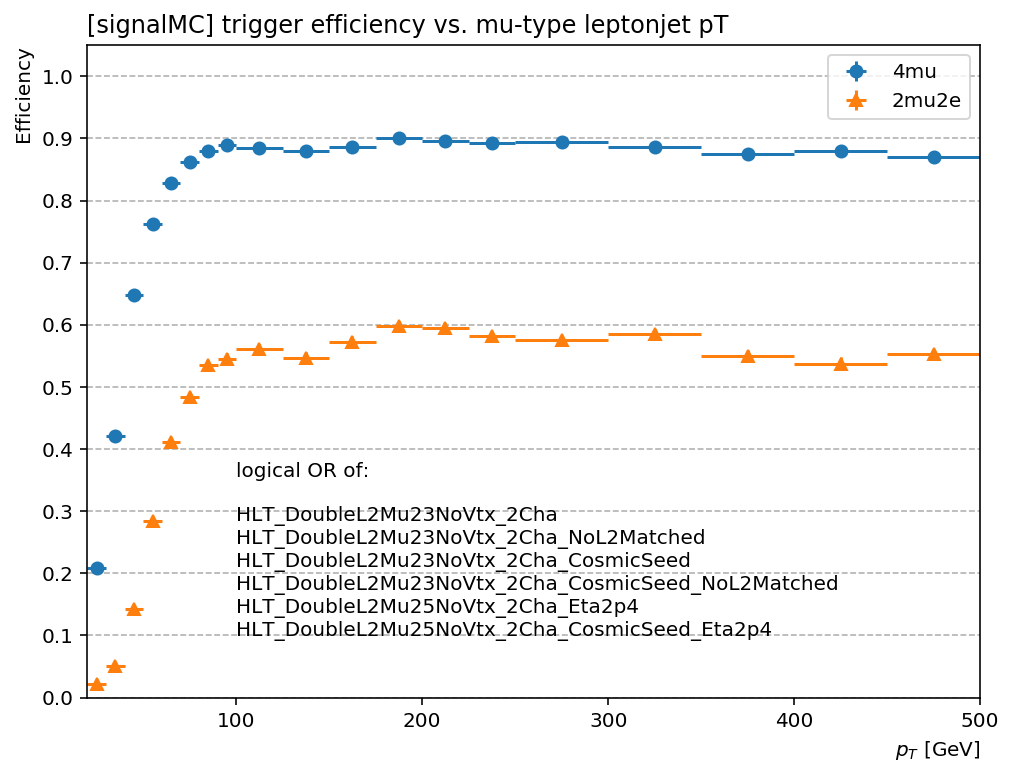

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['pt'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['pt'].integrate('dataset', '4mu').sum('trigger'),
               overflow='over',
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='4mu'
              )
hist.plotratio(num=output['pt'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['pt'].integrate('dataset', '2mu2e').sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='2mu2e'
              )
ax.text(100, 0.1, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

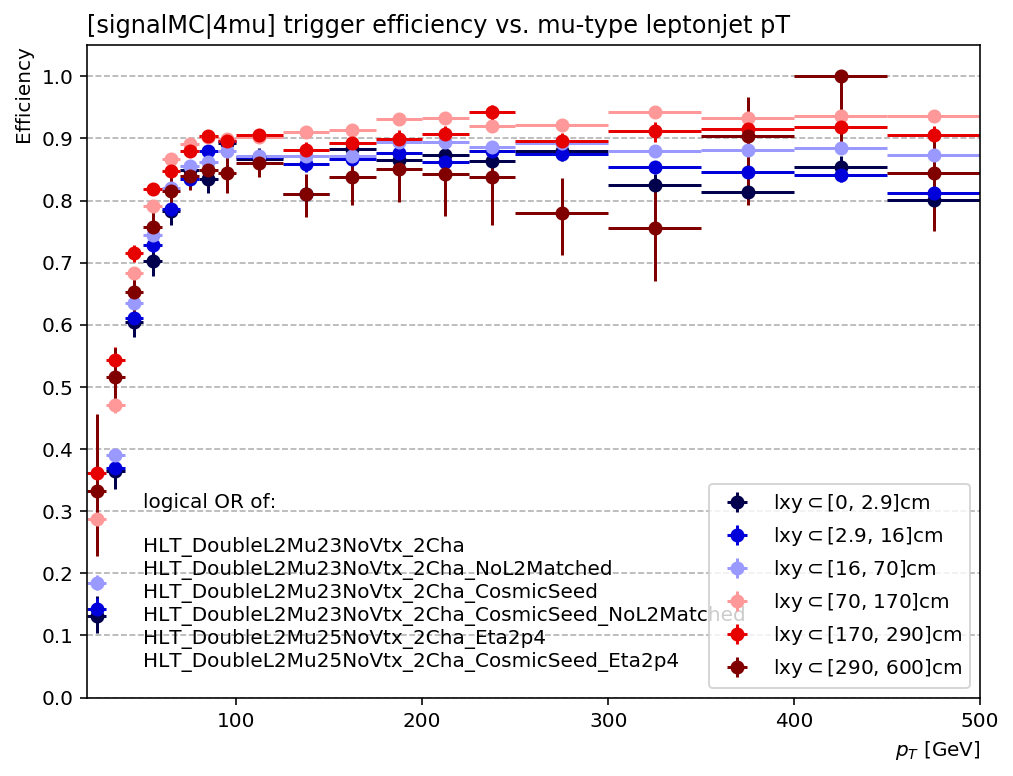

In [12]:
N = 6
old_cycle_style = plt.rcParams["axes.prop_cycle"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.seismic(np.linspace(0,1,N)))

fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(0,2.9)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(0,2.9)).sum('trigger'),
               overflow='over',
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[0, 2.9]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(2.9,16)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(2.9,16)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[2.9, 16]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(16, 70)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(16, 70)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[16, 70]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(70, 170)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(70, 170)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[70, 170]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(170, 290)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(170, 290)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[170, 290]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(290, 600)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '4mu').integrate('lxy', slice(290, 600)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': 'o', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[290, 600]cm'
              )

ax.text(50, 0.05, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC|4mu] trigger efficiency vs. mu-type leptonjet pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

plt.rcParams["axes.prop_cycle"] = old_cycle_style;

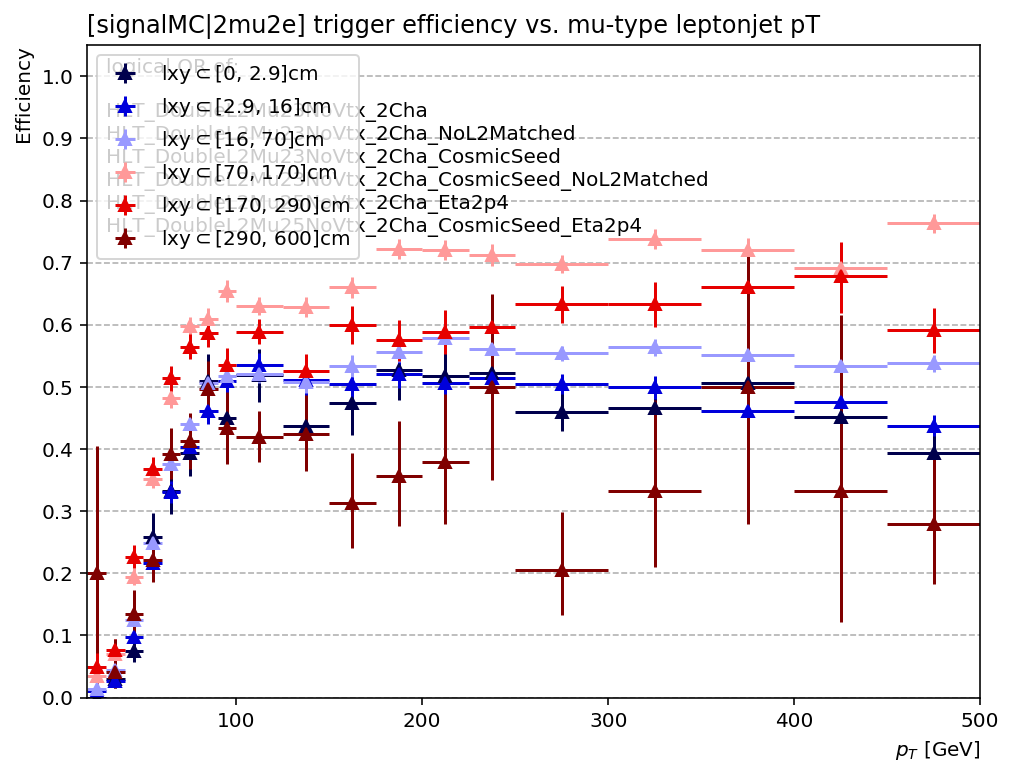

In [11]:
N = 6
old_cycle_style = plt.rcParams["axes.prop_cycle"]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.seismic(np.linspace(0,1,N)))

fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(0,2.9)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(0,2.9)).sum('trigger'),
               overflow='over',
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[0, 2.9]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(2.9,16)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(2.9,16)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[2.9, 16]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(16, 70)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(16, 70)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[16, 70]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(70, 170)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(70, 170)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[70, 170]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(170, 290)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(170, 290)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[170, 290]cm'
              )
hist.plotratio(num=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(290, 600)).integrate('trigger', 'true'),
               denom=output['pt_'].integrate('dataset', '2mu2e').integrate('lxy', slice(290, 600)).sum('trigger'),
               overflow='over',
               clear=False,
               error_opts={'marker': '^', 'xerr': ptBinWidth},
               ax=ax,
               label='lxy$\subset$[290, 600]cm'
              )

ax.text(30, 0.75, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_title('[signalMC|2mu2e] trigger efficiency vs. mu-type leptonjet pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right")

plt.rcParams["axes.prop_cycle"] = old_cycle_style;

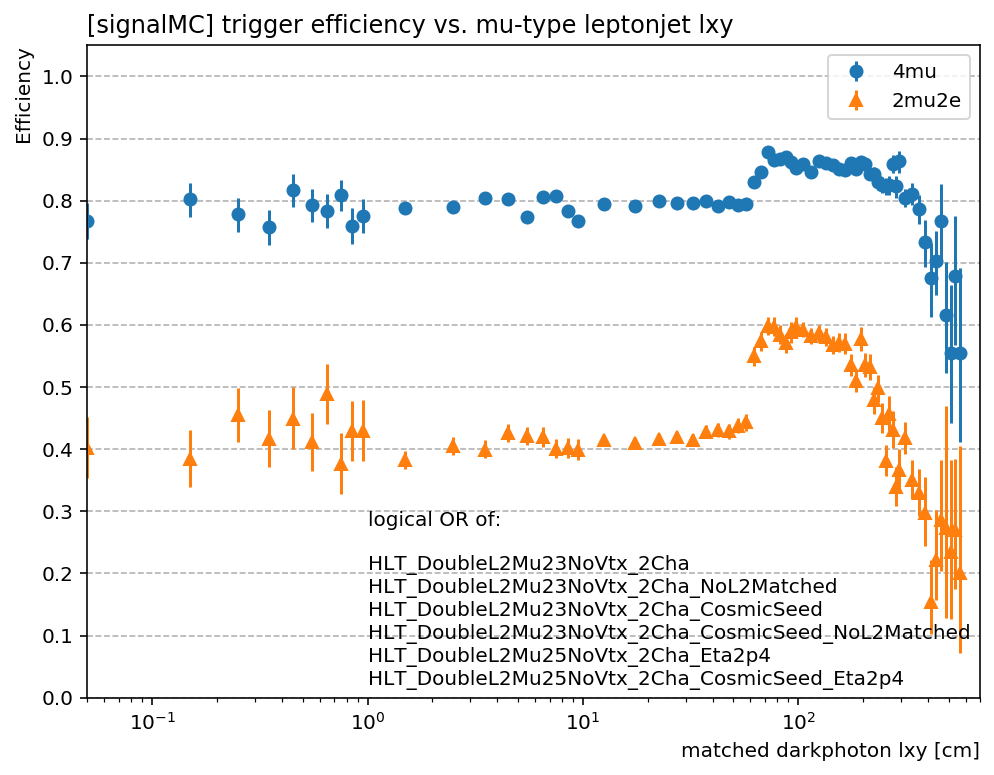

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dpvxy'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dpvxy'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               label='4mu'
              )
hist.plotratio(num=output['dpvxy'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dpvxy'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               label='2mu2e'
              )
ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
ax.set_xscale('log')
ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet lxy', x=0.0, ha="left")
ax.set_xlabel('matched darkphoton lxy [cm]', x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

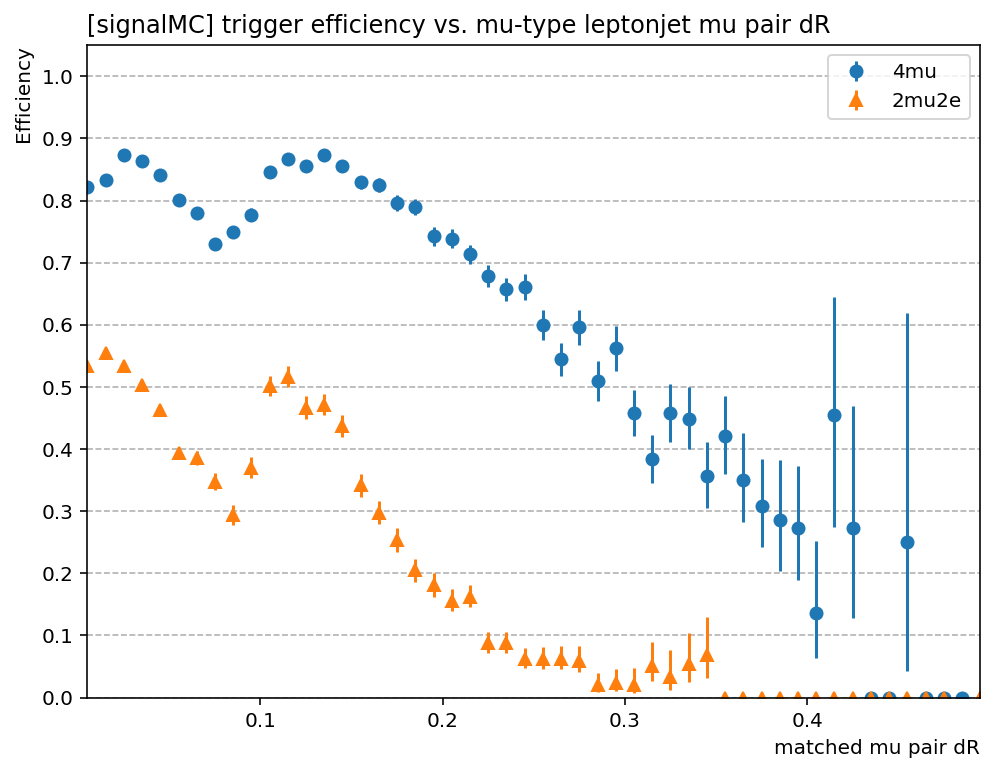

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dr'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dr'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               label='4mu'
              )
hist.plotratio(num=output['dr'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dr'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               label='2mu2e'
              )
# ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
# ax.set_xscale('log')
# ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet mu pair dR', x=0.0, ha="left")
ax.set_xlabel('matched mu pair dR', x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

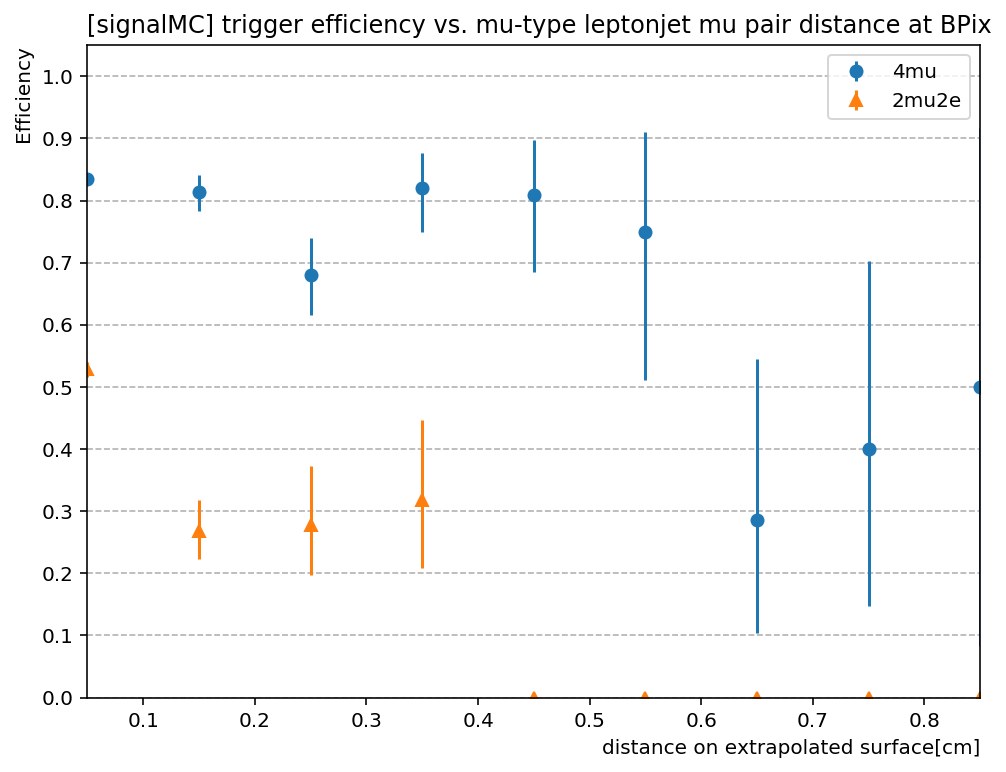

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dist0'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dist0'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               overflow='over',
               label='4mu'
              )
hist.plotratio(num=output['dist0'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dist0'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               overflow='over',
               label='2mu2e'
              )
# ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
# ax.set_xscale('log')
# ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet mu pair distance at BPix', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

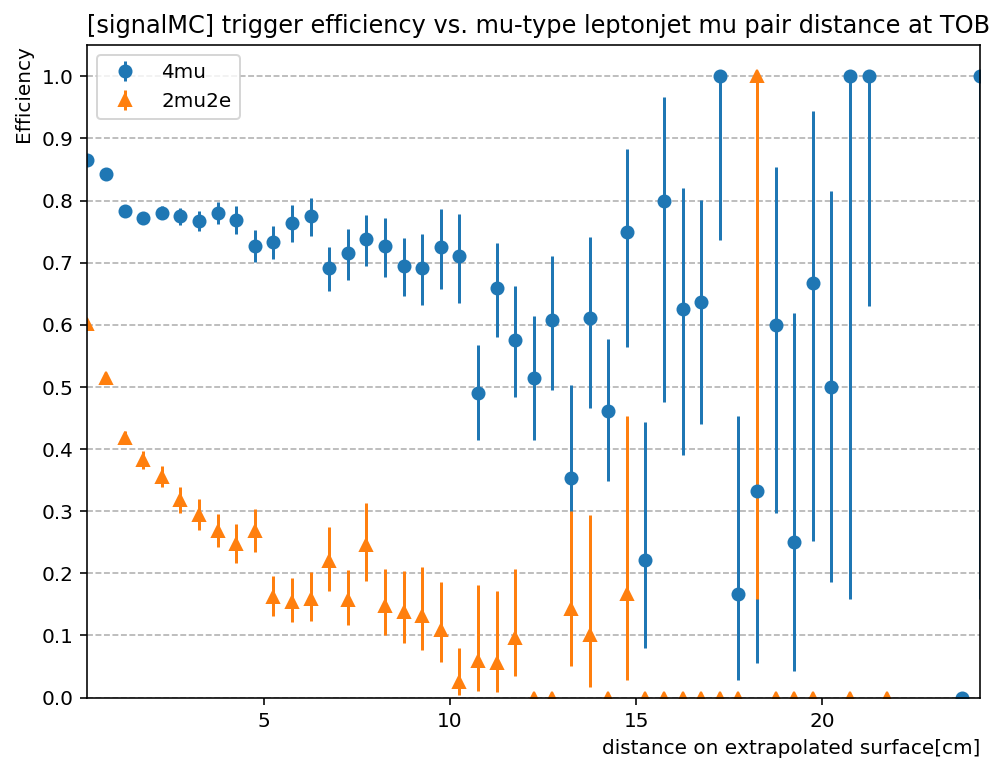

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dist1'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dist1'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               overflow='over',
               label='4mu'
              )
hist.plotratio(num=output['dist1'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dist1'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               overflow='over',
               label='2mu2e'
              )
# ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
# ax.set_xscale('log')
# ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet mu pair distance at TOB', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

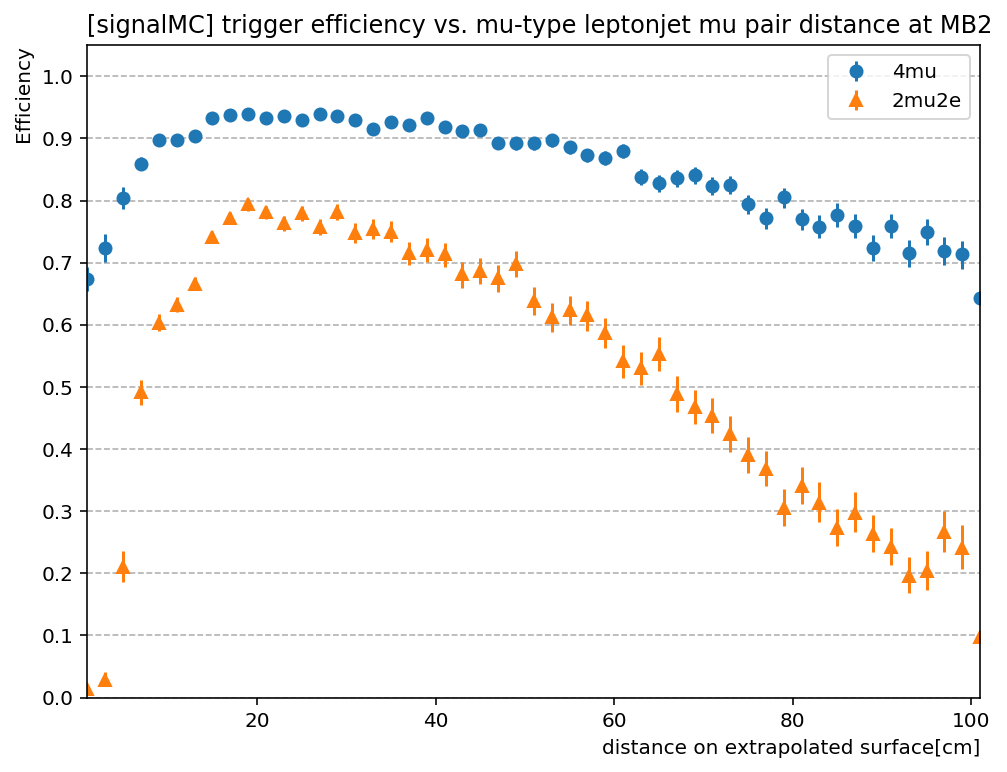

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dist2'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dist2'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               overflow='over',
               label='4mu'
              )
hist.plotratio(num=output['dist2'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dist2'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               overflow='over',
               label='2mu2e'
              )
# ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
# ax.set_xscale('log')
# ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet mu pair distance at MB2', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

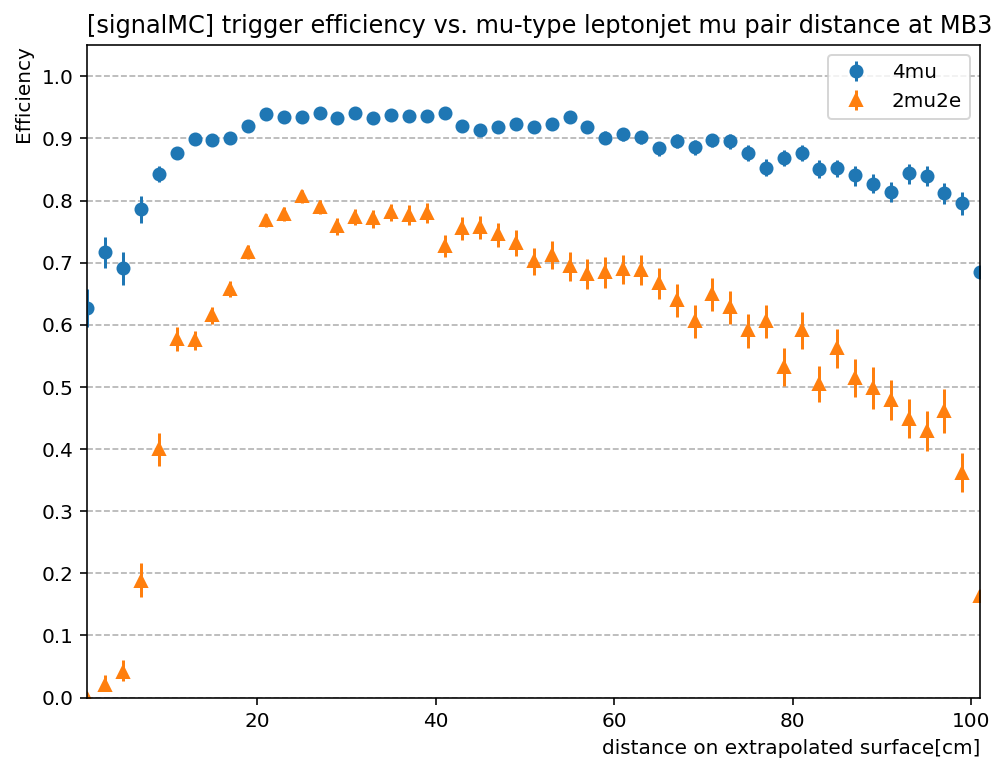

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

hist.plotratio(num=output['dist3'].integrate('dataset', '4mu').integrate('trigger', 'true'),
               denom=output['dist3'].integrate('dataset', '4mu').sum('trigger'),
               error_opts={'marker': 'o'},
               ax=ax,
               overflow='over',
               label='4mu'
              )
hist.plotratio(num=output['dist3'].integrate('dataset', '2mu2e').integrate('trigger', 'true'),
               denom=output['dist3'].integrate('dataset', '2mu2e').sum('trigger'),
               clear=False,
               error_opts={'marker': '^'},
               ax=ax,
               overflow='over',
               label='2mu2e'
              )
# ax.text(1, 0.02, '\n'.join(['logical OR of:\n',]+ Triggers))
ax.legend()
ax.set_ylim([0, 1.05])
ax.set_yticks(np.arange(0, 1.05, 0.1))
ax.grid(axis='y', ls='--')
# ax.set_xscale('log')
# ax.set_xlim([5e-2, 7e2])
ax.set_title('[signalMC] trigger efficiency vs. mu-type leptonjet mu pair distance at MB3', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel('Efficiency', y=1.0, ha="right");

In [ ]:
jja = awkward.JaggedArray.fromiter([[[0,1],[1,2]], [[4,5,6], []], [[7,8,9]]])

jjaf = jja.flatten()
jjaf[np.zeros(jjaf.size, dtype='int')]

jjaf.pad(1)

awkward.JaggedArray.fromoffsets(jja.offsets, awkward.JaggedArray.fromfolding(jjaf.flatten()[jjaf.starts], 1)).flatten(axis=1)

a = awkward.fromiter([[1, 3], [4, 5]])
b = a[a.counts > 10]
b[:,:1]

JaggedArray.fromoffsets(jja.offsets, jjaf.pad(1).fillna(-1)[:, -1:])

